In [289]:
import re
import numpy as np
import glob
import os

In [290]:
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

Current directory: /home/davide/Downloads/High-Performance-Computing-2024-main/Assignment/output


In [291]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.style.use('default') 
plt.rcParams.update({
    'figure.facecolor': 'None',
    'axes.facecolor': 'None',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.5,

    # remove borders
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,

    # ticks
    'xtick.color': 'lightgray',
    'ytick.color': 'lightgray',
    'xtick.direction': 'out',
    'ytick.direction': 'out',

    # grid
    'axes.grid': True,          # enable grid globally
    'grid.color': '#777777',  # very light gray
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,

    # lines
    'lines.linewidth': 1.0,

    # font
    'font.size': 10,
    'font.family': 'sans-serif',
    'text.color': 'gray',   # axis labels, titles, etc.
    'axes.labelcolor': 'gray',
})


<br>
<br>
<br>
<br>

# Load functions

In [292]:
def parse_timings_from_file(filename):
    """Extract timing values from one file."""
    timings = []
    tot_time = None
    with open(filename, "r") as f:
        for line in f:
            # match lines like "time total: 135.405116"
            match = re.search(r"time .*?:\s+([\d\.Ee+-]+)", line)
            if match:
                timings.append(float(match.group(1)))
            
            match_tot = re.search(r"Time .*?:\s+([\d\.Ee+-]+)", line)
            if match_tot:
                tot_time = float(match.group(1))
    return timings, tot_time


def collect_data(init_file = "output", folder = ""):
    # find files named like output${threads}P${P}
    files = glob.glob(folder + init_file + "*P*")

    threads_list = []
    all_timings = []

    for fname in files:
        # extract thread number from filename (between "output" and "P")
        match = re.search(r"outputT(\d+)P", fname)
        if not match:
            continue
        threads = int(match.group(1))

        timings = parse_timings_from_file(fname)

        threads_list.append(threads)
        all_timings.append(timings)

    array_T = np.array(threads_list)
    array_time = np.array(all_timings)

    return array_T, array_time

In [293]:
def parse_timings_from_file(filename):
    """Extract timing values from one file."""
    timings = []
    tot_time = None
    with open(filename, "r") as f:
        for line in f:
            # match lines like "time total: 135.405116"
            match = re.search(r"time .*?:\s+([\d\.Ee+-]+)", line)
            if match:
                timings.append(float(match.group(1)))
            
            match_tot = re.search(r"TimeTotalFile:\s+([\d\.Ee+-]+)", line)
            if match_tot:
                tot_time = float(match_tot.group(1))
    return timings, tot_time



def collect_data(init_file="output", folder=""):
    files = os.listdir(folder) #glob.glob(folder)

    threads_list = []
    n_list = []
    p_list = []
    tot_time_list = []
    all_timings = []

    for fname in files:
        # extract N, P, T values from filename
        
        splitted = re.split("N|P|T|.log", fname)
        print((splitted))
        N = int(splitted[1])
        P = int(splitted[2])
        try:
            T = int(splitted[3])
        except:
            T = int(splitted[3].split('x')[0])

        timings, tot_time = parse_timings_from_file(folder+ fname)

        tot_time_list.append(tot_time)
        n_list.append(N)
        p_list.append(P)
        threads_list.append(T)
        all_timings.append(timings)

    array_N = np.array(n_list)
    array_P = np.array(p_list)
    array_T = np.array(threads_list)
    array_time = np.array(all_timings)
    array_TotTime = np.array(tot_time_list)

    return array_N, array_P, array_T, array_time, array_TotTime


leoStrong_N, _, _, leoStrong_time, leoStrong_totTimes = collect_data("leonardo_", "Leonardo/Strong/")
leoStrong_totTimes

['leonardo_', '8', '64', '8', '']
['leonardo_', '1', '8', '8', '']
['leonardo_', '2', '16', '8', '']
['leonardo_', '4', '32', '8', '']
['leonardo_', '16', '128', '8', '']


array([13.52188688, 90.27295765, 46.24515719, 23.90587049,  8.91977396])

In [294]:
_, _, array_T, array_time, _ = collect_data("output_", "Orfeo/OpenMP/")
array_T

['orfeo_', '1', '1', '4', '']
['orfeo_', '1', '1', '2', '']
['orfeo_', '1', '1', '128', '']
['orfeo_', '1', '1', '8', '']
['orfeo_', '1', '1', '16', '']
['orfeo_', '1', '1', '64', '']
['orfeo_', '1', '1', '32', '']
['orfeo_', '1', '1', '1', '']


array([  4,   2, 128,   8,  16,  64,  32,   1])

<br>
<br>

## Plots

In [295]:
def plotTime(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx][:, 0]

    serial = times[0] if serial is None else serial

    if totTimes is not None:
        totTimes = totTimes[idx]
        serial = totTimes[0]
        times = totTimes

    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  times, color = "#E2B1FF", label='real')

    x_ideal = np.linspace(x[0], x[-1], 200)
    ax.plot(x_ideal, serial/x_ideal, linestyle = "--", color = "#FFA0D4", label='ideal' )

    ax.set_xscale("log")
    ax.set_xticks(x )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.set_title('Time vs ' + x_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Time (s)")
    ax.set_ylim((-0.05, np.max(times)*1.1))
    ax.legend()
    plt.show()
    

In [296]:
def plotTimeWeak(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx][:, 0]

    serial = times[0] if serial is None else serial

    if totTimes is not None:
        totTimes = totTimes[idx]
        serial = totTimes[0]
        times = totTimes

    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  times, color = "#E2B1FF", label='real')

    ax.hlines(serial, x[0], x[-1], linestyle = "--", color = "#FFA0D4", label='ideal')

    ax.set_xscale("log")
    ax.set_xticks(x )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.set_title('Time vs ' + x_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Time (s)")
    ax.set_ylim((np.min(times)*0.8, np.max(times)*1.1))
    ax.legend()
    plt.show()
    

In [297]:
def speedUp(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx][:, 0]

    serial = times[0] if serial is None else serial

    if totTimes is not None:
        totTimes = totTimes[idx]
        serial = totTimes[0]
        times = totTimes
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  serial/times, color = "#E2B1FF", label='real')

    x_ideal = np.linspace(x[0], x[-1], 200)
    ax.plot(x_ideal, x_ideal, linestyle = "--", color = "#FFA0D4", label='ideal')

    ax.set_xticks(x )

    ax.set_title('Speed up')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Speed up")
    ax.set_ylim((-0.05, x[-1]*1.1))
    ax.legend()
    plt.show()

In [298]:
def efficiency(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx][:, 0]

    serial = times[0] if serial is None else serial

    if totTimes is not None:
        totTimes = totTimes[idx]
        serial = totTimes[0]
        times = totTimes
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  serial/(times*x), color = "#E2B1FF", label='real')

    ax.hlines(1, x[0], x[-1], linestyle = "--", color = "#FFA0D4", label='ideal')

    ax.set_xscale("log")
    ax.set_xticks(x )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.set_title('Efficiency')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Efficiency")
    ax.set_ylim((-0.05, 1.1))
    ax.legend()
    plt.show()

In [299]:
def efficiencyWeak(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx][:, 0]

    serial = times[0] if serial is None else serial

    if totTimes is not None:
        totTimes = totTimes[idx]
        serial = totTimes[0]
        times = totTimes
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  serial/times, color = "#E2B1FF", label='real')

    ax.hlines(1, x[0], x[-1], linestyle = "--", color = "#FFA0D4", label='ideal')

    ax.set_xscale("log")
    ax.set_xticks(x )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.set_title('Efficiency')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Efficiency")
    ax.set_ylim((-0.05, 1.1))
    ax.legend()
    plt.show()

In [300]:
def percentagesPlot(x, times, totTimes = None, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x  = x[idx]
    times = times[idx][:, 1:-1]

    print(times.shape)
    if totTimes is not None:
        totTimes = totTimes[idx]
        overhead = totTimes - np.sum(times, axis=-1)
        times = np.hstack([times, overhead[:, None]])

    timeTot = times.sum(axis=-1)
    timesPercentage = times/timeTot[:,None]

    rowLabels = np.array(["Fill Buffers", 
                          "Update center",
                          "wait EAST WEST",
                          "compute EAST WEST",
                          "wait NORTH SOUTH",
                          "compute NORTH SOUTH",
                          "initialization"])

    colors = np.array([ "#F2FF00", 
                        "#86FF76",
                        "#8F9FFF",
                        "#0026FF",
                        "#FF8989",
                        "#FF0000",
                        "#FFFFFF"])

    fig, ax = plt.subplots(figsize = (10, 5))
    n_rows, n_cols = timesPercentage.shape
    cumulative = np.zeros(n_rows)

    for j in range(n_cols):
        ax.bar(range(n_rows), timesPercentage[:, j], bottom=cumulative, color=colors[j], label=rowLabels[j], zorder=2)
        cumulative += timesPercentage[:, j]

    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', 
              borderaxespad=0., frameon=True)
    
    ax.set_title('Time Percentages')
    ax.set_xticks(range(n_rows))
    ax.set_xticklabels([cpu for cpu in x])

    ax.set_ylabel("Time %")
    ax.set_xlabel(x_label)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


<br>
<br>
<br>
<br>
<br>
<br>

# Orfeo

## Orfeo OpenMP

In [301]:
_, _, orfeo_T, orfeo_time, _ = collect_data("orfeo_", "Orfeo/OpenMP/")
orfeo_T

['orfeo_', '1', '1', '4', '']
['orfeo_', '1', '1', '2', '']
['orfeo_', '1', '1', '128', '']
['orfeo_', '1', '1', '8', '']
['orfeo_', '1', '1', '16', '']
['orfeo_', '1', '1', '64', '']
['orfeo_', '1', '1', '32', '']
['orfeo_', '1', '1', '1', '']


array([  4,   2, 128,   8,  16,  64,  32,   1])

In [302]:
idx = np.argsort(orfeo_T)
orfeo_T[idx]

array([  1,   2,   4,   8,  16,  32,  64, 128])

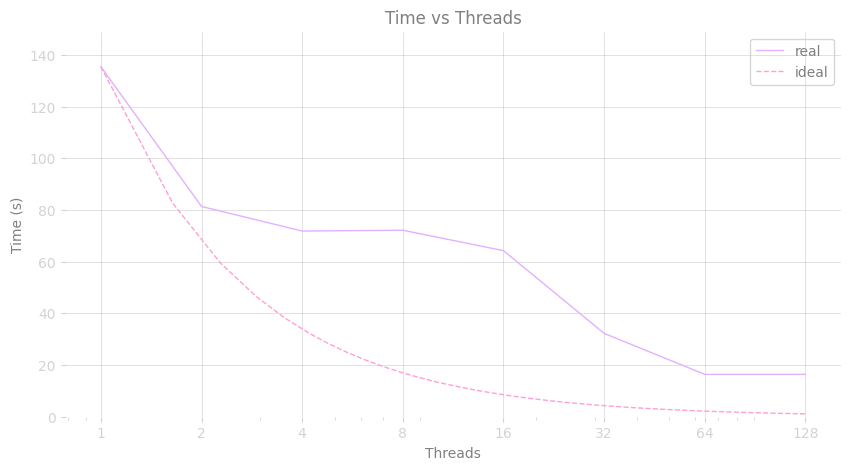

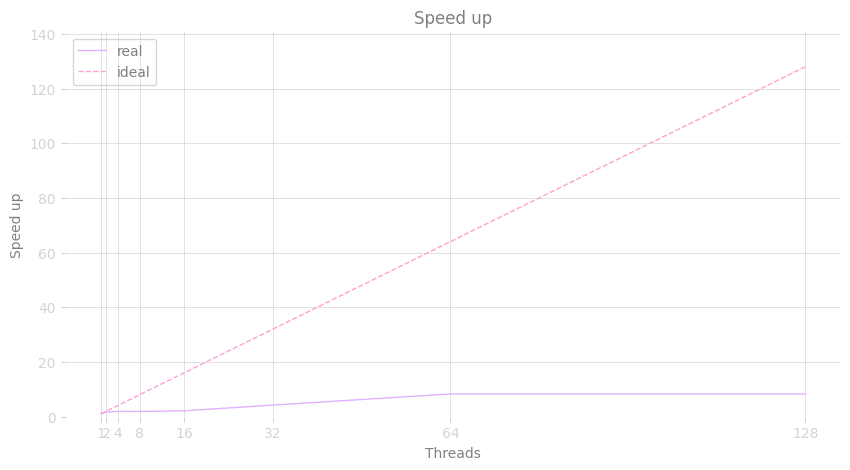

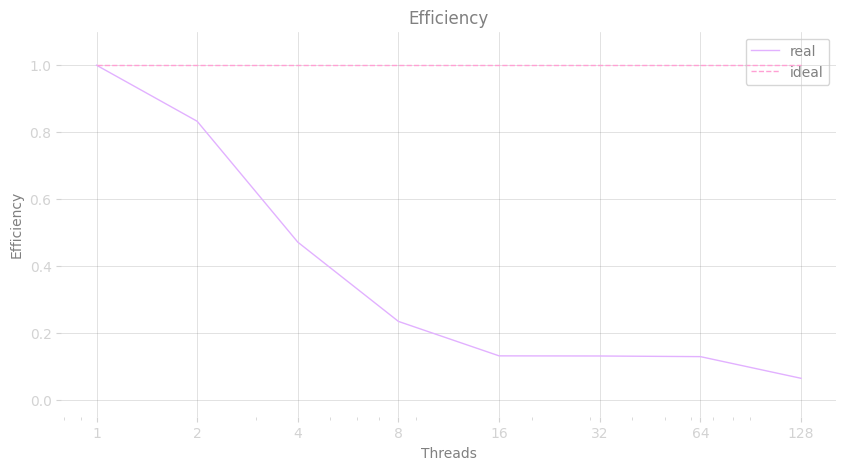

(8, 6)


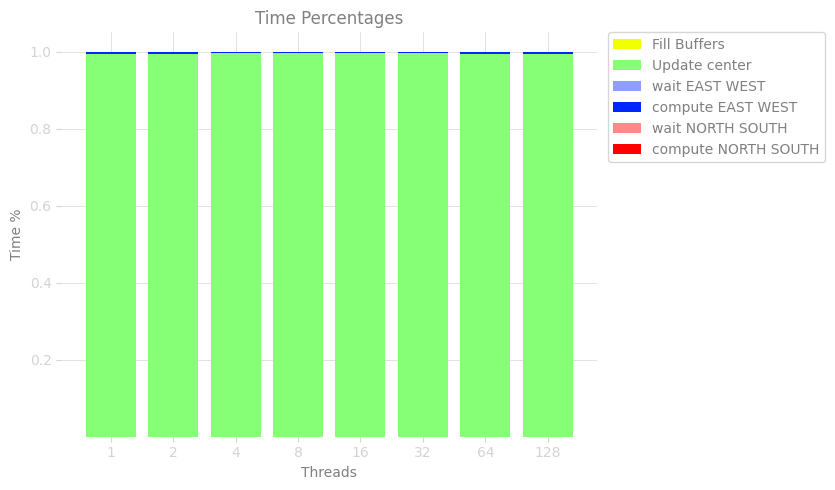

In [303]:
plotTime(orfeo_T, array_time)
speedUp(array_T, array_time)
efficiency(array_T, array_time)
percentagesPlot(array_T, array_time)

## Orfeo Strong

In [304]:
orfeoStrong_N, _, _, orfeoStrong_time, _ = collect_data("orfeo_", "Orfeo/Strong/")
orfeoStrong_N

['output_', '1', '8', '4', ' ']
['output_', '2', '16', '4', '']


array([1, 2])

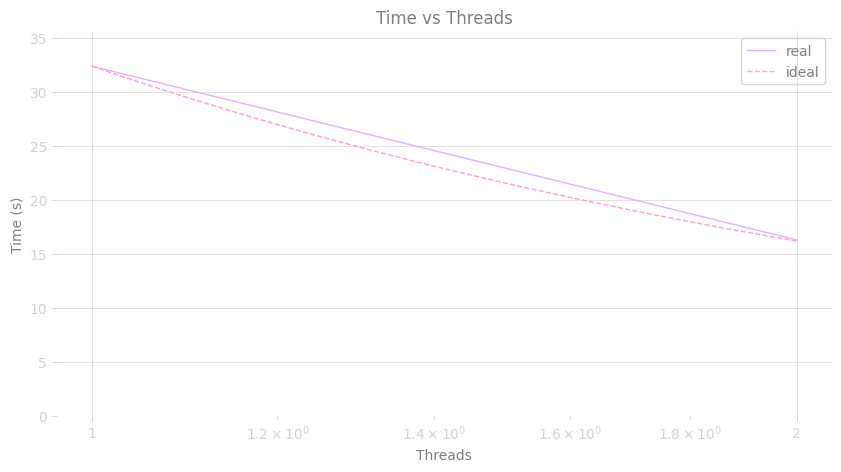

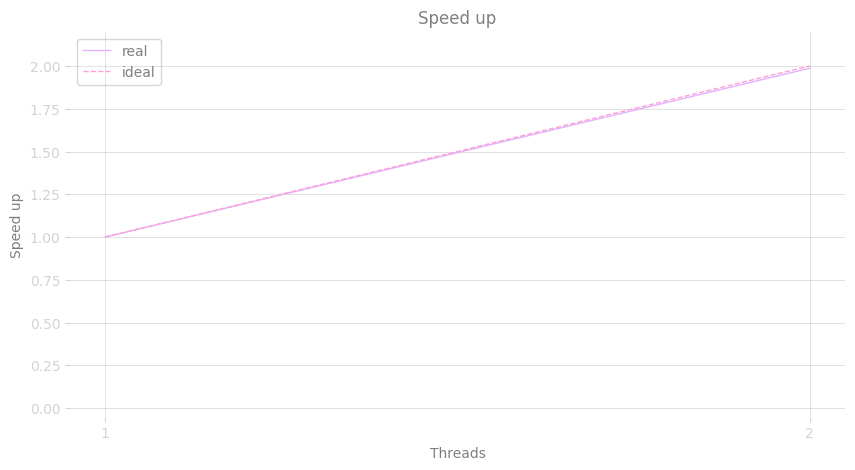

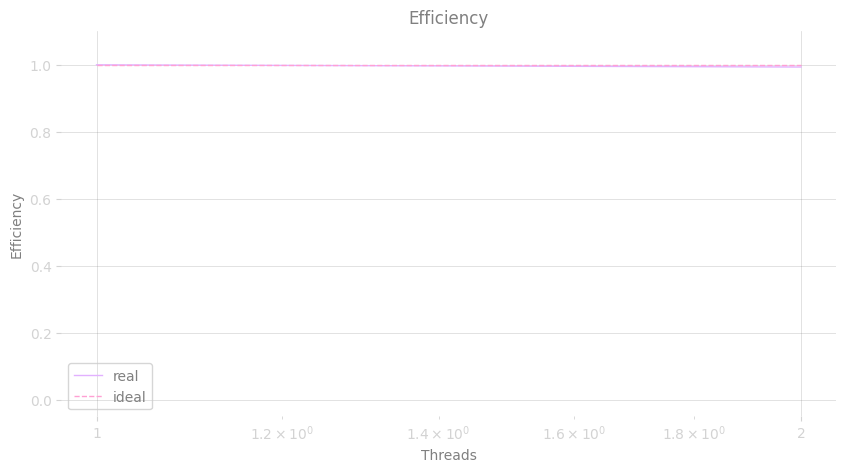

(2, 6)


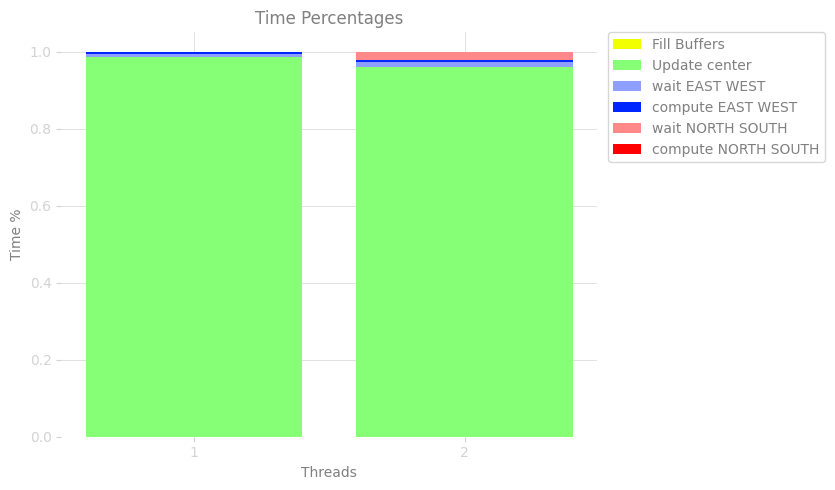

In [305]:
plotTime(orfeoStrong_N, orfeoStrong_time)
speedUp(orfeoStrong_N, orfeoStrong_time)
efficiency(orfeoStrong_N, orfeoStrong_time)
percentagesPlot(orfeoStrong_N, orfeoStrong_time)

## Orfeo Weak

In [306]:
orfeoWeak_N, _, _, orfeoWeak_time, orfeoWeak_Totaltime = collect_data("orfeo_", "Orfeo/Weak/")
orfeoWeak_Totaltime

['orfeo_', '1', '8', '16x16384y16384', '']
['orfeo_', '2', '16', '16x32768y16384', '']


array([22.95263876, 26.14300734])

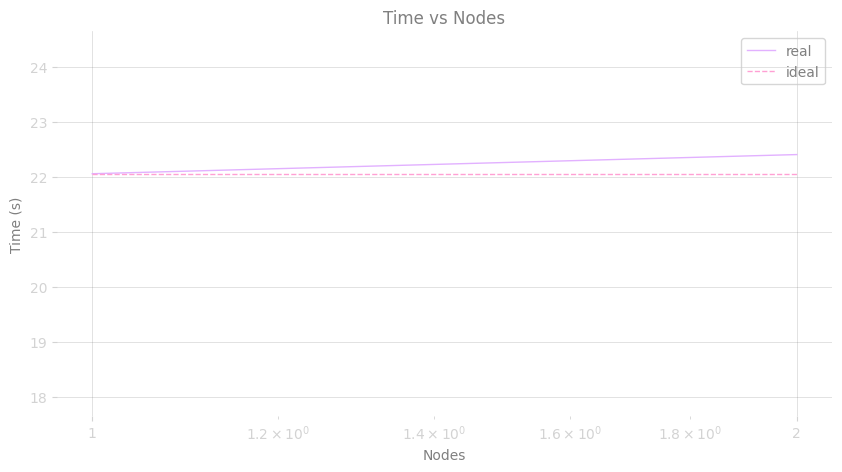

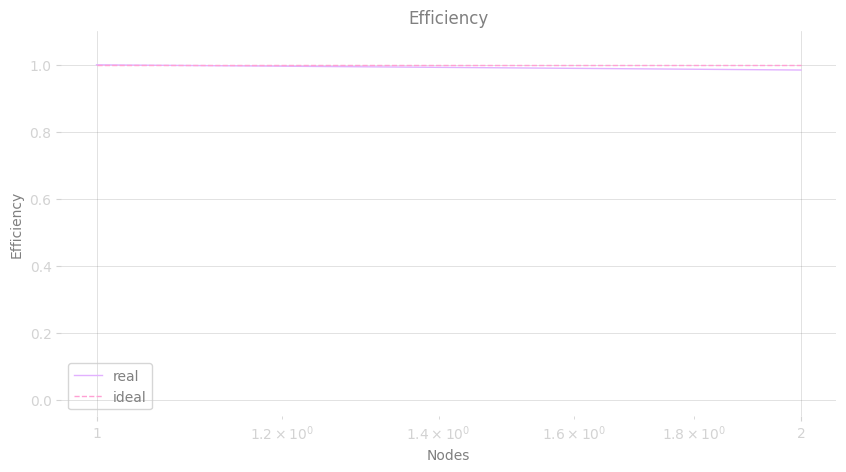

(2, 6)


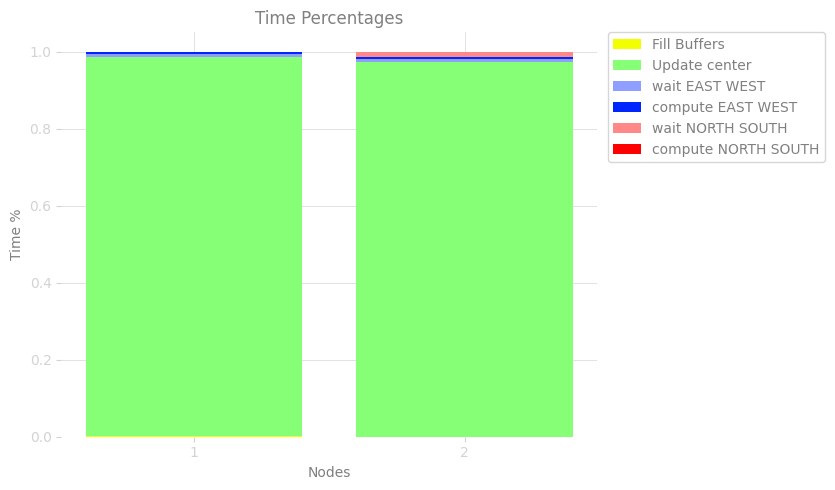

In [307]:
plotTimeWeak(orfeoWeak_N, orfeoWeak_time,  x_label="Nodes")
efficiencyWeak(orfeoWeak_N, orfeoWeak_time,  x_label="Nodes")
percentagesPlot(orfeoWeak_N, orfeoWeak_time,  x_label="Nodes")

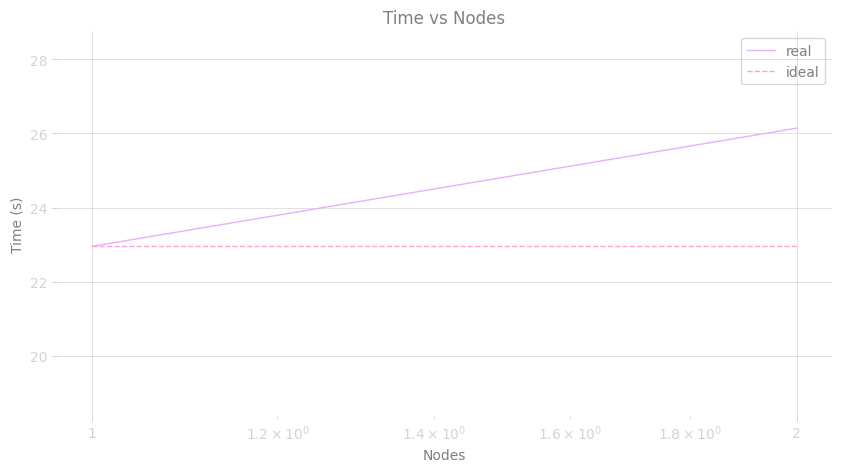

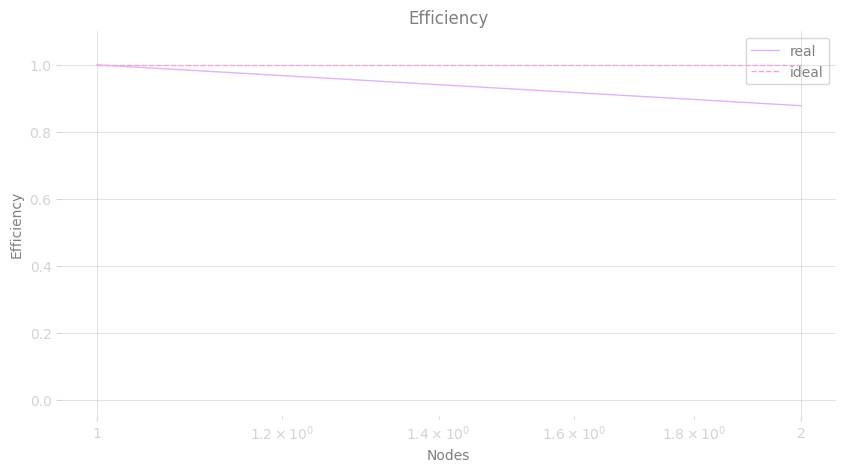

(2, 6)


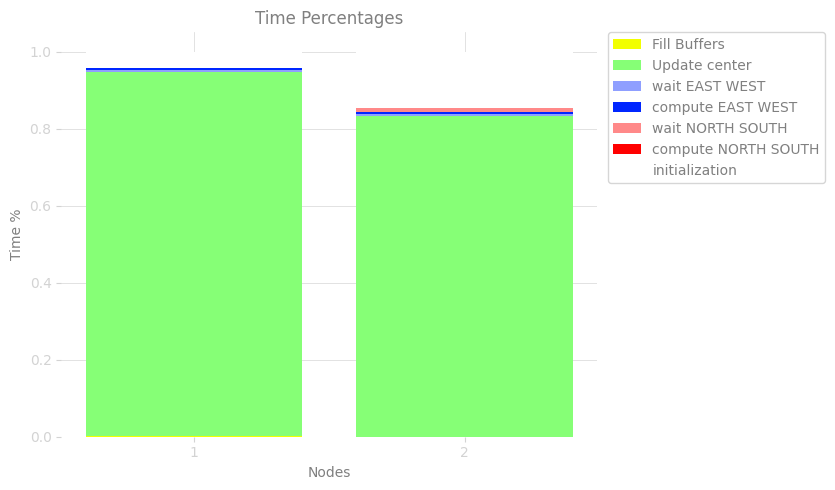

In [308]:
plotTimeWeak(orfeoWeak_N, orfeoWeak_time, orfeoWeak_Totaltime,  x_label="Nodes")
efficiencyWeak(orfeoWeak_N, orfeoWeak_time, orfeoWeak_Totaltime,  x_label="Nodes")
percentagesPlot(orfeoWeak_N, orfeoWeak_time, orfeoWeak_Totaltime,  x_label="Nodes")

<br>
<br>
<br>
<br>
<br>
<br>

# Leonardo

## Leonardo OpenMP

In [309]:
_, _, leo_T, leo_time, _ = collect_data("leonardo_", "Leonardo/OpenMP/")
leo_T

['leonardo_', '1', '1', '8', '']
['leonardo_', '1', '1', '2', '']
['leonardo_', '1', '1', '64', '']
['leonardo_', '1', '1', '32', '']
['leonardo_', '1', '1', '16', '']
['leonardo_', '1', '1', '1', '']
['leonardo_', '1', '1', '4', '']
['leonardo_', '1', '1', '112', '']


array([  8,   2,  64,  32,  16,   1,   4, 112])

In [310]:
leo_idx = np.argsort(leo_T)
leo_T[leo_idx]

array([  1,   2,   4,   8,  16,  32,  64, 112])

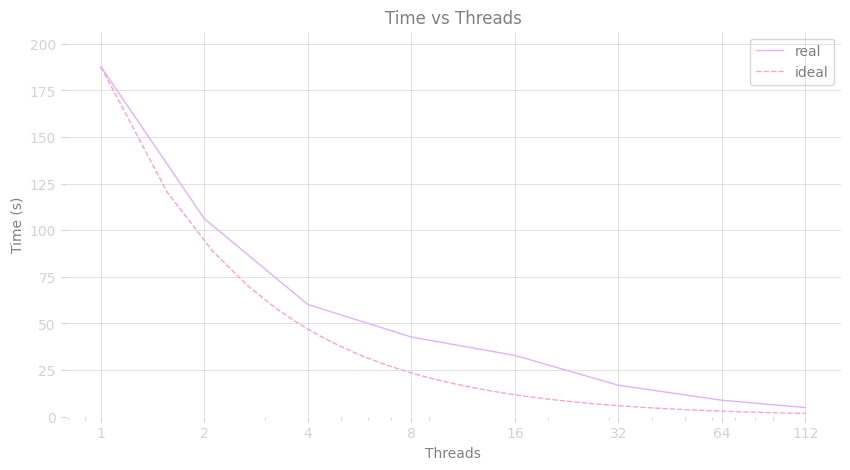

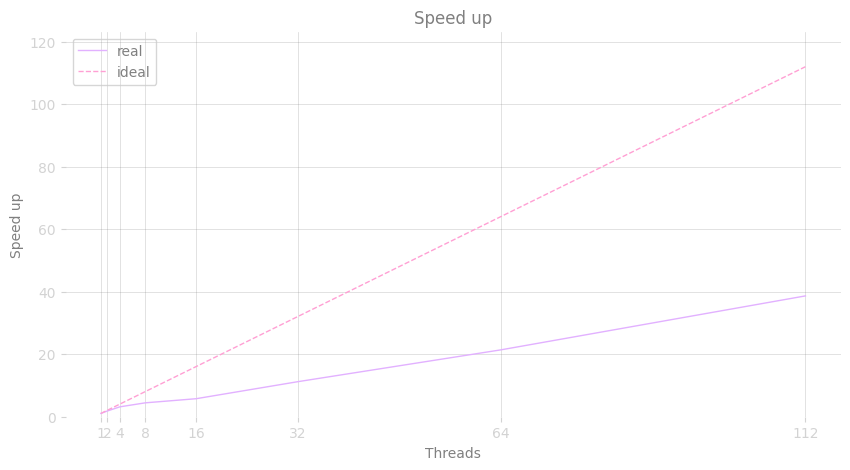

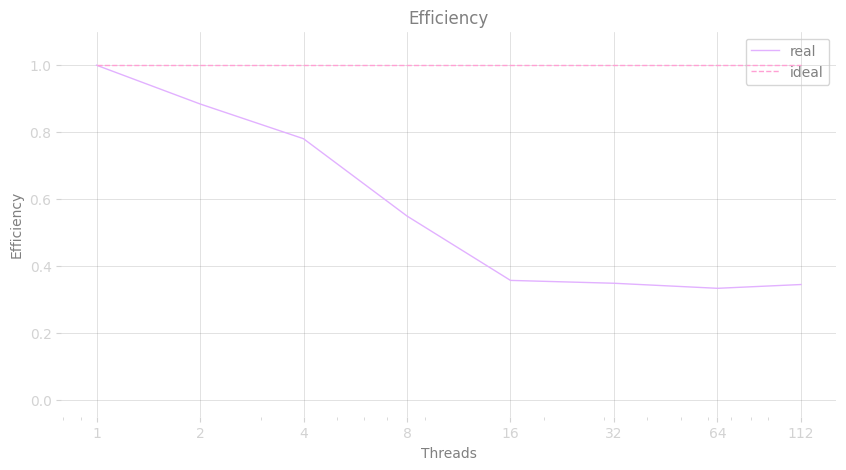

(8, 6)


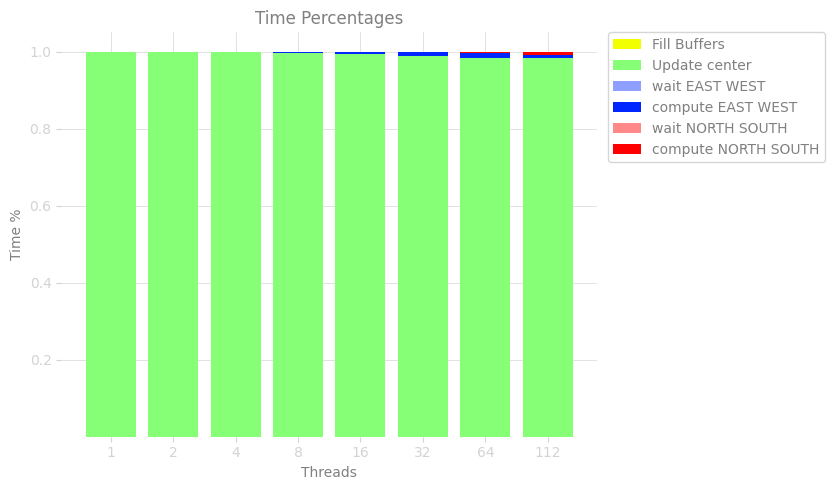

In [311]:
plotTime(leo_T, leo_time)
speedUp(leo_T, leo_time)
efficiency(leo_T, leo_time)
percentagesPlot(leo_T, leo_time)

## Leonardo Strong

In [312]:
leoStrong_N, _, _, leoStrong_time, leoStrong_totTimes = collect_data("leonardo_", "Leonardo/Strong/")
leoStrong_totTimes

['leonardo_', '8', '64', '8', '']
['leonardo_', '1', '8', '8', '']
['leonardo_', '2', '16', '8', '']
['leonardo_', '4', '32', '8', '']
['leonardo_', '16', '128', '8', '']


array([13.52188688, 90.27295765, 46.24515719, 23.90587049,  8.91977396])

In [313]:
leoStrong_totTimes[None, :]

array([[13.52188688, 90.27295765, 46.24515719, 23.90587049,  8.91977396]])

In [314]:
np.hstack([leoStrong_time, leoStrong_totTimes[:, None]]).shape

(5, 9)

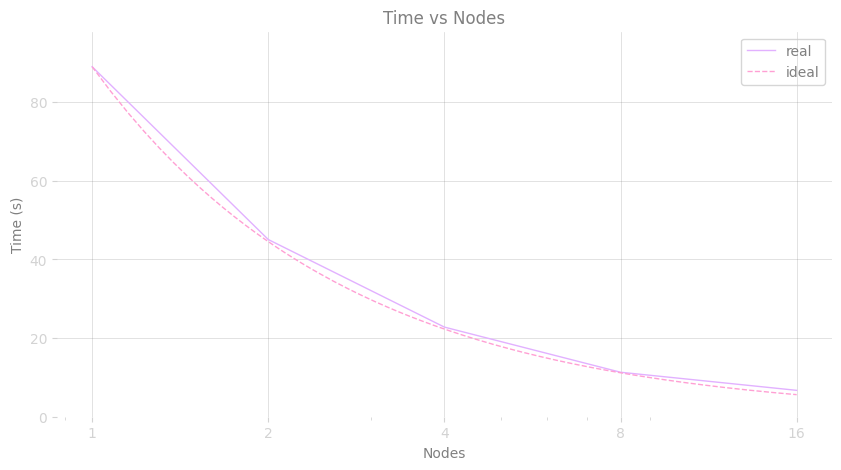

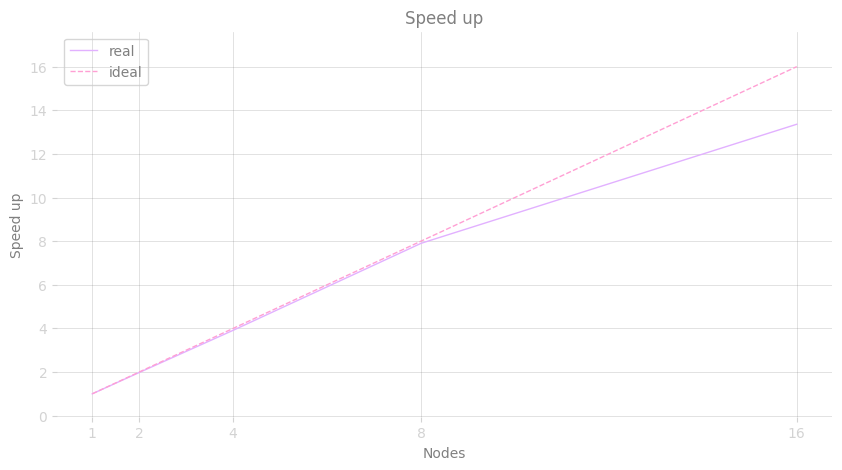

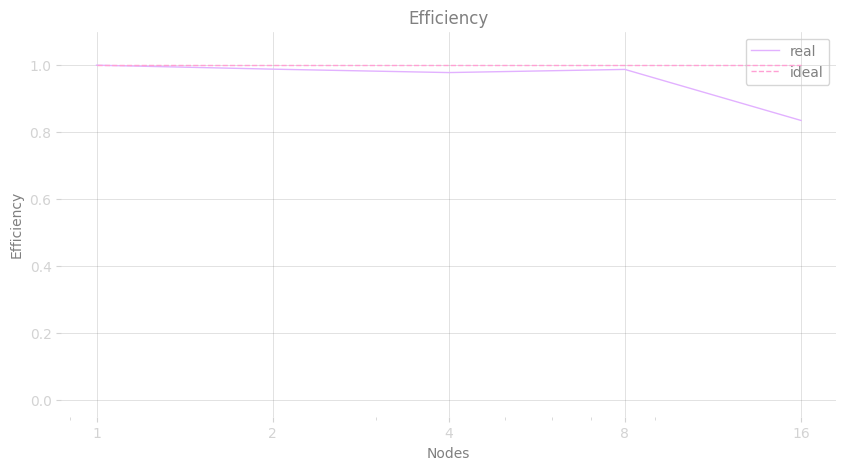

(5, 6)


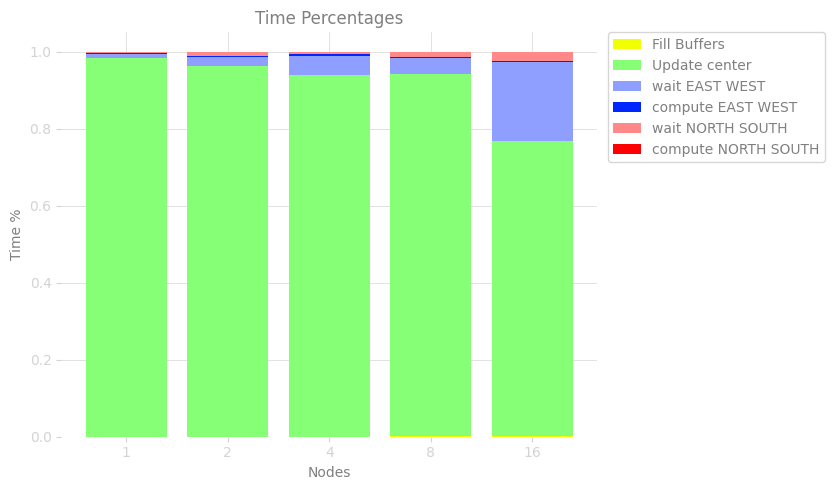

In [315]:
plotTime(leoStrong_N, leoStrong_time, x_label="Nodes")
speedUp(leoStrong_N, leoStrong_time,  x_label="Nodes")
efficiency(leoStrong_N, leoStrong_time,  x_label="Nodes")
percentagesPlot(leoStrong_N, leoStrong_time,  x_label="Nodes")

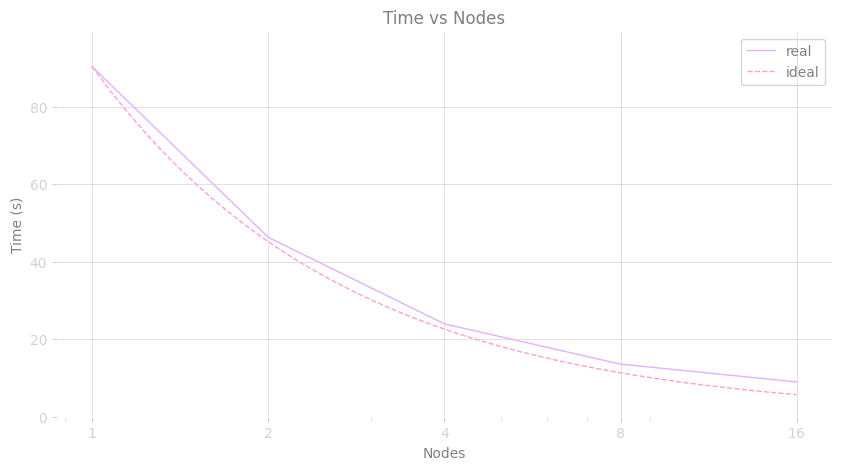

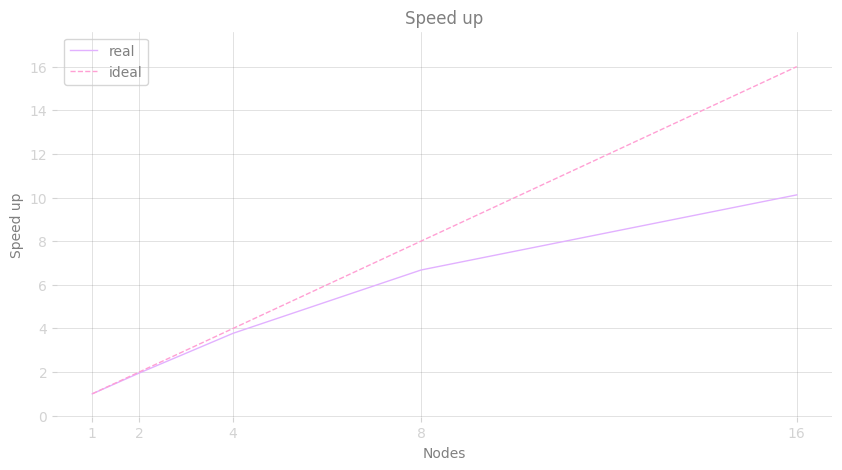

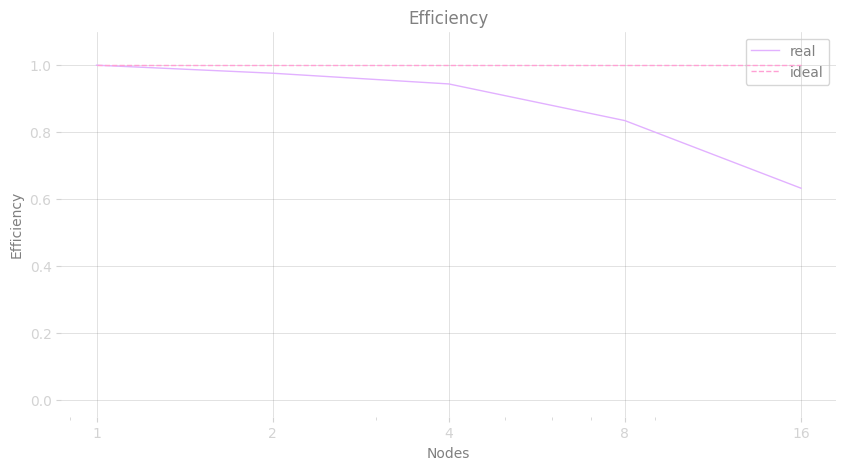

(5, 6)


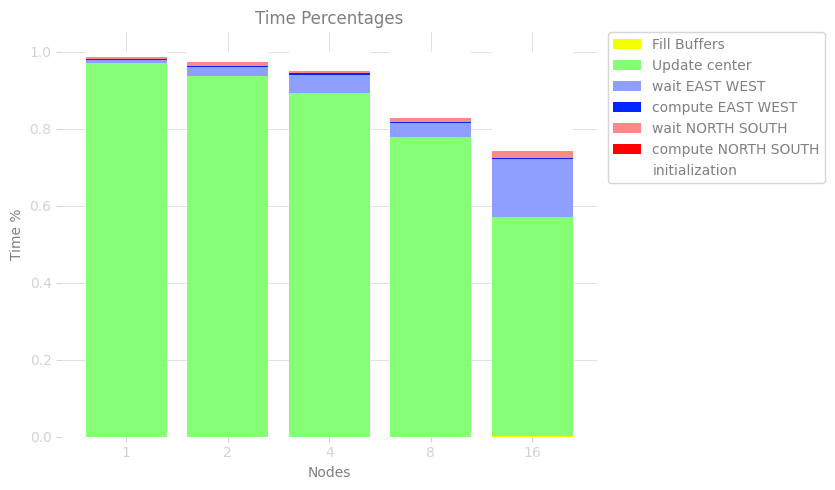

In [316]:
plotTime(leoStrong_N, leoStrong_time, leoStrong_totTimes,  x_label="Nodes")
speedUp(leoStrong_N, leoStrong_time, leoStrong_totTimes,  x_label="Nodes")
efficiency(leoStrong_N, leoStrong_time, leoStrong_totTimes,  x_label="Nodes")
percentagesPlot(leoStrong_N, leoStrong_time, leoStrong_totTimes,  x_label="Nodes")

## Leonardo Weak

In [317]:
leoWeak_N, _, _, leoWeak_time, leoWeak_Totaltime = collect_data("leonardo_", "Leonardo/Weak/")
leoWeak_time

['leonardo_', '1', '8', '8x16384y16384', '']
['leonardo_', '8', '64', '8x65536y32768', '']
['leonardo_', '16', '128', '8x65536y65536', '']
['leonardo_', '4', '32', '8x32768y32768', '']
['leonardo_', '2', '16', '8x32768y16384', '']


array([[2.2840281e+01, 8.1090000e-03, 2.2041624e+01, 4.9675000e-01,
        7.3244000e-02, 1.7561400e-01, 1.0343000e-02, 7.5595000e-01],
       [2.2660505e+01, 8.7680000e-03, 2.1396623e+01, 8.8755800e-01,
        6.9163000e-02, 2.3389500e-01, 1.6963000e-02, 1.2075790e+00],
       [2.2425300e+01, 8.5880000e-03, 2.0726889e+01, 1.3360960e+00,
        8.9780000e-02, 2.1174700e-01, 9.9560000e-03, 1.6475790e+00],
       [2.2788800e+01, 8.5650000e-03, 2.1283989e+01, 1.0898930e+00,
        7.9908000e-02, 2.7550000e-01, 1.0151000e-02, 1.4554520e+00],
       [2.3100461e+01, 8.9880000e-03, 2.1877215e+01, 7.8022600e-01,
        7.1162000e-02, 2.9619900e-01, 1.7693000e-02, 1.1652810e+00]])

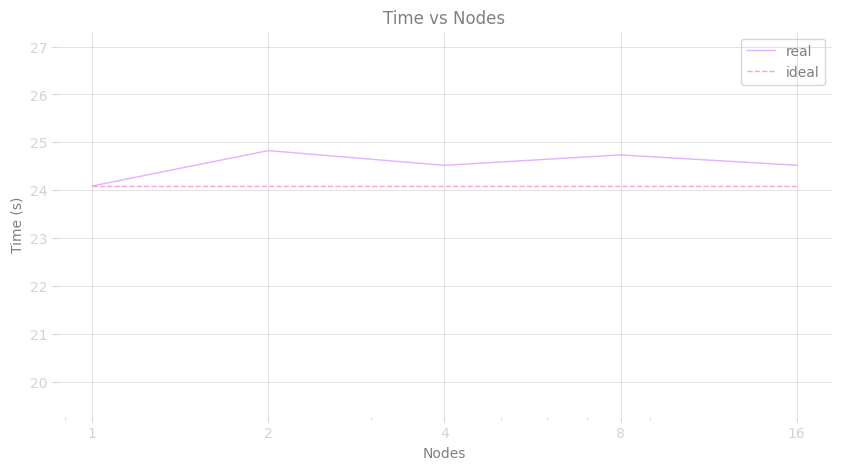

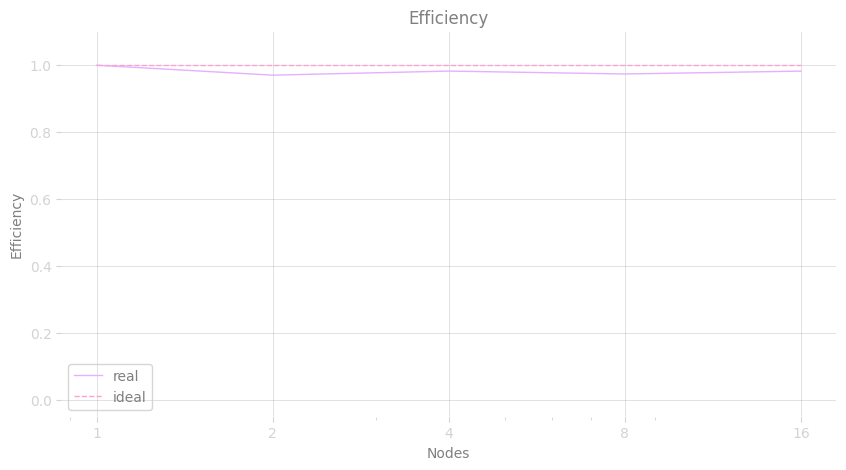

(5, 6)


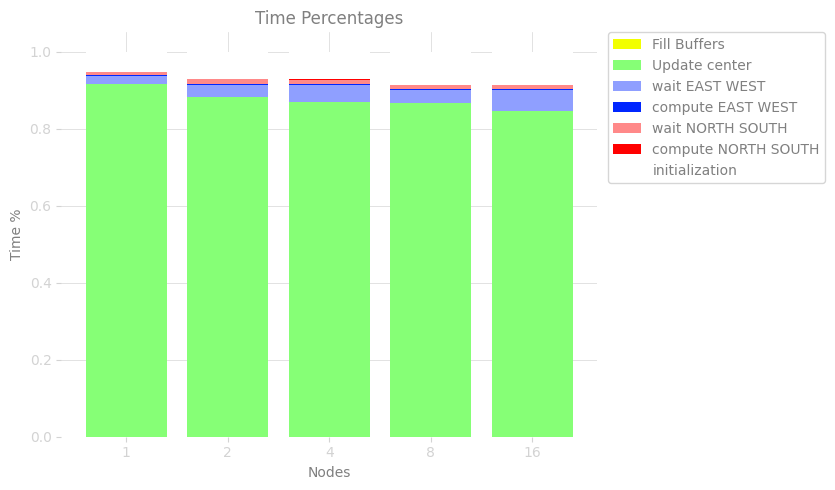

In [318]:
plotTimeWeak(leoWeak_N, leoWeak_time, leoWeak_Totaltime,  x_label="Nodes")
efficiencyWeak(leoWeak_N, leoWeak_time, leoWeak_Totaltime,  x_label="Nodes")
percentagesPlot(leoWeak_N, leoWeak_time, leoWeak_Totaltime,  x_label="Nodes")